In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr
import scipy.interpolate as scint

start_path=os.getcwd()
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"

synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
retrieval_src_path=my_git_path+"/hamp_retrieval_haloac3/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,synth_ar_path+"src/")
sys.path.insert(4,synth_ar_path+"plotting/")
sys.path.insert(5,hamp_processing_path)
sys.path.insert(6,hamp_processing_path+"plotting/")
sys.path.insert(7,retrieval_src_path+"src/")
sys.path.insert(8,start_path+"/../plotting/")
import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA 
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

import matplotlib

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
def plot_vertical_sonde_profiles_for_sector_legs(Dropsondes_dict,legs,relevant_sondes,plot_path):
    matplotlib.rcParams.update({"font.size":16})
    sonde_fig=plt.subplots(nrows=4, ncols=4,figsize=(12,18))
    #for s,sonde in enumerate([*Dropsondes_dict[leg]["q"].keys()]):
    #if s in relevant_warm_sector_sondes[leg+"_in"]:
        
    ax1=sonde_fig.add_subplot(431)
    ax2=sonde_fig.add_subplot(432)
    ax3=sonde_fig.add_subplot(133,sharey=ax2)
    ax1.plot(Moisture_CONV.sector_sonde_values[sector_to_plot]["q"]*1000,
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
                                  color="lightblue",lw=1)
    mean_sector_q=Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].mean(axis=1)
    ax1.plot(mean_sector_q*1000,mean_sector_q.index/1000,color="darkblue",lw=2)

    ax1.set_ylim([0,12])
    ax2.set_ylim([0,12])
    ax3.set_ylim([0,12])

    ax1.set_xlim([0,6])
    #wind speed
    ax2.plot(Moisture_CONV.sector_sonde_values[sector_to_plot]["wind"],
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
         color="thistle",lw=1)
    mean_sector_wind=Moisture_CONV.sector_sonde_values[sector_to_plot]["wind"].mean(axis=1)
    ax2.plot(mean_sector_wind,mean_sector_wind.index/1000,color="purple",lw=2)
    ax2.set_xlim([0,50])
    #transport
    mean_sector_transport=Moisture_CONV.sector_sonde_values[sector_to_plot]["transport"].mean(axis=1)
    ax3.plot(Moisture_CONV.sector_sonde_values[sector_to_plot]["transport"],
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
                                  color="darkseagreen")
    ax3.plot(mean_sector_transport,
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
                                  lw=2,color="darkgreen")
    ax3.set_xlim([0,0.15])
    ax2.set_yticklabels([])
    ax3.set_yticklabels([])
    ax1.set_xlabel("Specific Humidity (g/kg)")
    ax2.set_xlabel("Wind speed (m/s)")
    ax3.set_xlabel("Moisture Transport (g/kgms)")

    ax1.yaxis.set_tick_params(width=2,length=6)
    ax1.xaxis.set_tick_params(width=2,length=6)
    ax2.yaxis.set_tick_params(width=2,length=6)
    ax2.xaxis.set_tick_params(width=2,length=6)
    ax3.yaxis.set_tick_params(width=2,length=6)
    ax3.xaxis.set_tick_params(width=2,length=6)
    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(3)
        ax2.spines[axis].set_linewidth(3)
        ax3.spines[axis].set_linewidth(3)
    ax1.set_ylabel("Height (km)")
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    plt.suptitle("Sonde Moisture transport convergence "+flight[0]+" "+ar_of_day+" "+sector_to_plot)
    
    sns.despine(offset=10,ax=ax1)
    sns.despine(offset=10,ax=ax2)
    sns.despine(offset=10,ax=ax3)
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_Sondes.png"
    sonde_fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)

In [11]:
relevant_warm_sector_sondes={}
relevant_warm_sector_sondes["RF05_AR_entire_1_in"]=[0,1,2,3]
relevant_warm_sector_sondes["RF05_AR_entire_1_out"]=[9,10,11,12]

relevant_warm_sector_sondes["RF05_AR_entire_2_out"] = [9,10,11,12]
relevant_warm_sector_sondes["RF05_AR_entire_2_in"]= [15,16,17,18]

relevant_warm_sector_sondes["RF06_AR_entire_1_in"]=[0,1,2]
relevant_warm_sector_sondes["RF06_AR_entire_1_out"]=[8,9,10]

relevant_warm_sector_sondes["RF06_AR_entire_2_in"]=[8,9]
relevant_warm_sector_sondes["RF06_AR_entire_2_out"]=[16,17]

AR_entire_1
AR_entire_2
AR_entire_1
AR_entire_2


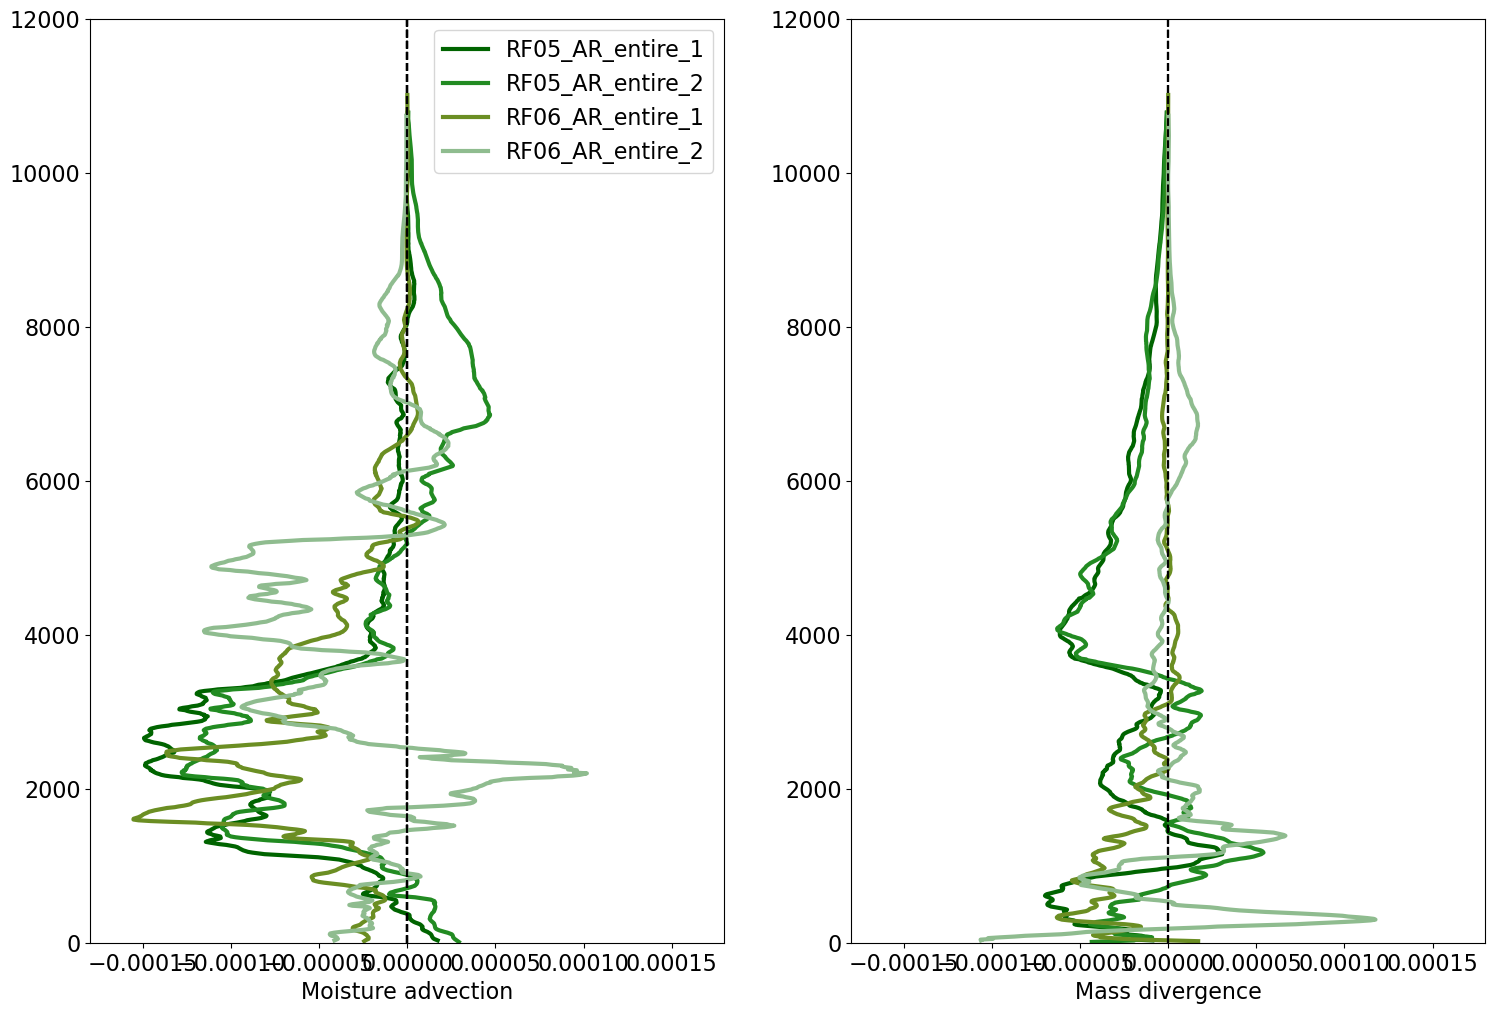

In [12]:
from simplified_flight_leg_handling import simplified_run_grid_main

import matplotlib.pyplot as plt
sonde_budget_path=major_work_path+"//HALO_AC3/data/budgets/"#RF06_AR_entire_2_warm_Real_Sondes_adv_q.csv
tendency_nabla_ivt={}
tendency_nabla_ivt["adv_q"]={}
tendency_nabla_ivt["mass_conv"]={}
tendency_nabla_ivt["sum"]={}
sector_colors=["darkgreen","forestgreen","olivedrab","darkseagreen"]
#unc_colors=[,"lightcyan","mintcream","palegoldenrod"]
div_trend_fig=plt.figure(figsize=(18,12))
ax1=div_trend_fig.add_subplot(121)
ax2=div_trend_fig.add_subplot(122)
Dropsondes_dict={}

for l,leg in enumerate(["RF05_AR_entire_1","RF05_AR_entire_2","RF06_AR_entire_1","RF06_AR_entire_2"]):
    rf=leg.split("_")[0]
    ar_of_day=leg.split("_")[-3]+"_"+leg.split("_")[-2]+"_"+leg.split("_")[-1]
    print(ar_of_day)
    with HiddenPrints():
        halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes_dict[leg]=\
            simplified_run_grid_main(flight=[rf],config_file_path=major_work_path,ar_of_day=ar_of_day)
    adv_file_name=rf+"_"+ar_of_day+"_warm_Real_Sondes_"+"adv_q"+".csv"
    mass_file_name=rf+"_"+ar_of_day+"_warm_Real_Sondes_"+"mass_convergence"+".csv"
    #print(file_name)
    tendency_nabla_ivt["adv_q"][leg]=pd.read_csv(sonde_budget_path+adv_file_name,index_col=0)
    tendency_nabla_ivt["mass_conv"][leg]=pd.read_csv(sonde_budget_path+mass_file_name,index_col=0)
    tendency_nabla_ivt["sum"][leg]=tendency_nabla_ivt["adv_q"][leg]+\
                                    tendency_nabla_ivt["mass_conv"][leg]
    ax1.plot(tendency_nabla_ivt["adv_q"][leg]["val"].values,
             tendency_nabla_ivt["adv_q"][leg].index,label=leg,color=sector_colors[l],lw=3)
    ax1.set_xlabel("Moisture advection")
    ax1.axvline(x=0,ymin=0,ymax=12000,color="k",ls="--")
    ax2.plot(tendency_nabla_ivt["mass_conv"][leg]["val"].values,
             tendency_nabla_ivt["mass_conv"][leg].index,label=leg,color=sector_colors[l],lw=3)
    ax2.set_xlabel("Mass divergence")
    ax1.axvline(x=0,ymin=0,ymax=12000,color="k",ls="--")
    ax2.axvline(x=0,ymin=0,ymax=12000,color="k",ls="--")
    ax1.set_ylim([0,12000])
    ax1.set_xlim([-1.8e-4,1.8e-4])
    ax2.set_ylim([0,12000])
    ax2.set_xlim([-1.8e-4,1.8e-4])
ax1.legend()

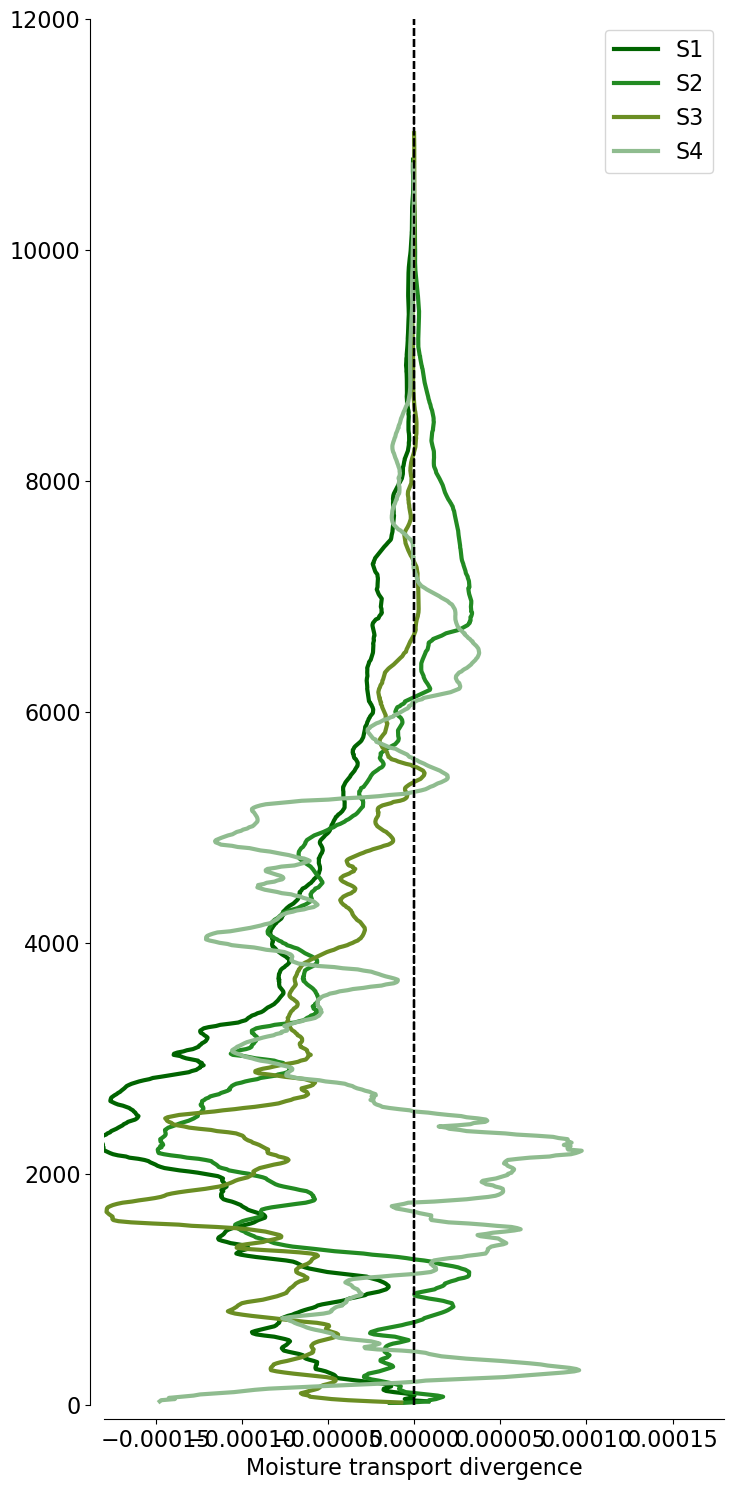

In [13]:
import seaborn as sns
transport_fig=plt.figure(figsize=(8,18))
ax1=transport_fig.add_subplot(111)
for l,leg in enumerate(["RF05_AR_entire_1","RF05_AR_entire_2","RF06_AR_entire_1","RF06_AR_entire_2"]):
    rf=leg.split("_")[0]
    ar_of_day=leg.split("_")[-3]+"_"+leg.split("_")[-2]+"_"+leg.split("_")[-1]
    
    ax1.plot(tendency_nabla_ivt["sum"][leg]["val"].values,
             tendency_nabla_ivt["sum"][leg].index,label="S"+str(l+1),color=sector_colors[l],lw=3)
    ax1.set_xlabel("Moisture transport divergence")
    ax1.axvline(x=0,ymin=0,ymax=12000,color="k",ls="--")
    ax1.axvline(x=0,ymin=0,ymax=12000,color="k",ls="--")
    ax1.set_ylim([0,12000])
    ax1.set_xlim([-1.8e-4,1.8e-4])
ax1.legend()
sns.despine(offset=10)

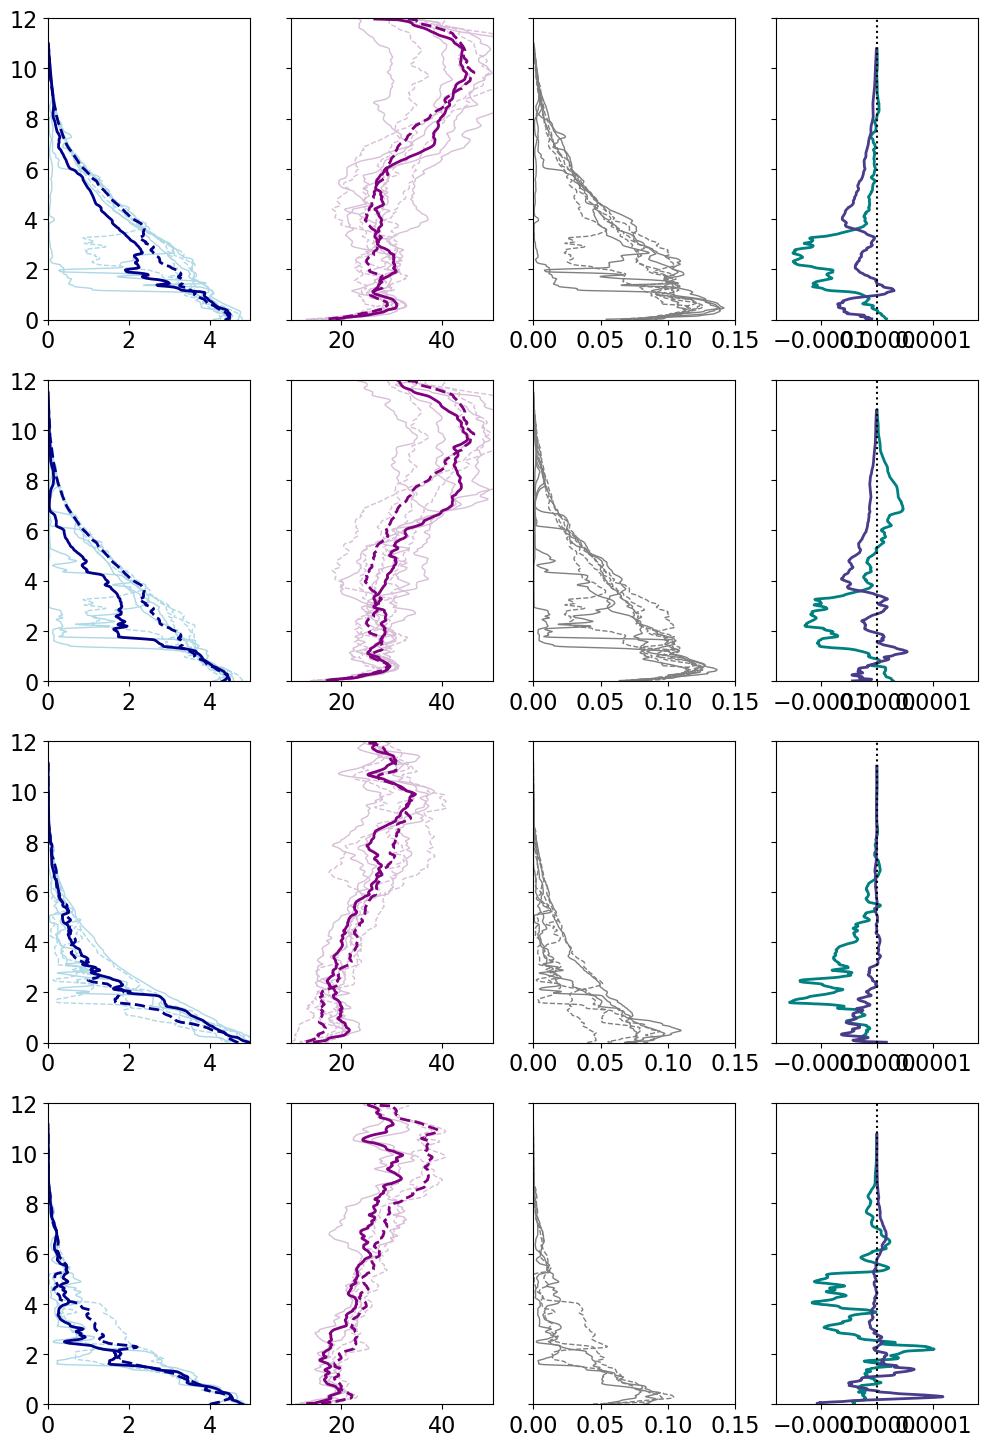

In [29]:
matplotlib.rcParams.update({"font.size":16})
sonde_fig,axs=plt.subplots(nrows=4, ncols=4,figsize=(12,18),sharey=True)
new_index=np.arange(0,12000,30)
                                
for l,leg in enumerate(["RF05_AR_entire_1","RF05_AR_entire_2","RF06_AR_entire_1","RF06_AR_entire_2"]):
    relevant_times=[*Dropsondes_dict[leg]["reference_time"].keys()]
    uninterp_vars={}
    interp_vars={}
    interp_vars_df_in={}
    interp_vars_df_in["q"]     = pd.DataFrame()
    interp_vars_df_in["v"]     = pd.DataFrame()
    interp_vars_df_in["tra"] = pd.DataFrame()
    interp_vars_df_out={}
    interp_vars_df_out["q"]     = pd.DataFrame()
    interp_vars_df_out["v"]     = pd.DataFrame()
    interp_vars_df_out["tra"] = pd.DataFrame()
    for s,sonde in enumerate([*Dropsondes_dict[leg]["q"].keys()]):
        key=[*Dropsondes_dict[leg]["q"].keys()][s]
        Dropsondes_dict[leg]["transport"]={}
        Dropsondes_dict[leg]["transport"][key]=Dropsondes_dict[leg]["q"][key]*\
                Dropsondes_dict[leg]["wspd"][str(relevant_times[s])]
        if s in relevant_warm_sector_sondes[leg+"_in"]:
            q_values  = Dropsondes_dict[leg]["q"][key].values
            z_values  = Dropsondes_dict[leg]["alt"][str(relevant_times[s])]
            v_values  = Dropsondes_dict[leg]["wspd"][str(relevant_times[s])].values
            tra_values= Dropsondes_dict[leg]["transport"][key].values

            q_series=pd.Series(data=q_values,index=z_values)
            q_series.dropna(inplace=True)
            
            v_series=pd.Series(data=v_values,index=z_values)
            v_series.dropna(inplace=True)
            v_series=v_series[v_series.index.notnull()]
            
            tra_series=pd.Series(data=tra_values,index=z_values)
            tra_series.dropna(inplace=True)
            uninterp_vars["q"]=q_series
            uninterp_vars["v"]=v_series
            uninterp_vars["tra"]=tra_series
            for var in ["q","v","tra"]:
                interp_func=scint.interp1d(uninterp_vars[var].index,
                            uninterp_vars[var],kind="nearest",bounds_error=False,fill_value=np.nan)

                interp_vars[var]=pd.Series(data=interp_func(new_index),
                                    index=new_index)
                interp_vars_df_in[var][sonde]=interp_vars[var]
            
            leg_type="in"
        elif s in relevant_warm_sector_sondes[leg+"_out"]:
            q_values  = Dropsondes_dict[leg]["q"][key].values
            z_values  = Dropsondes_dict[leg]["alt"][str(relevant_times[s])]
            v_values  = Dropsondes_dict[leg]["wspd"][str(relevant_times[s])].values
            tra_values= Dropsondes_dict[leg]["transport"][key].values
            q_series=pd.Series(data=q_values,index=z_values)
            q_series.dropna(inplace=True)
            q_series=q_series[q_series.index.notnull()]
            v_series=pd.Series(data=v_values,index=z_values)
            v_series.dropna(inplace=True)
            v_series=v_series[v_series.index.notnull()]
            tra_series=pd.Series(data=tra_values,index=z_values)
            tra_series.dropna(inplace=True)
            leg_type="out"
            
            uninterp_vars["q"]=q_series
            uninterp_vars["v"]=v_series
            uninterp_vars["tra"]=tra_series
            for var in ["q","v","tra"]:
                interp_func=scint.interp1d(uninterp_vars[var].index,
                            uninterp_vars[var],kind="nearest",bounds_error=False)
                
                interp_vars[var]=pd.Series(data=interp_func(new_index),
                                    index=new_index)
                interp_vars_df_out[var][sonde]=interp_vars[var]

        else: 
            continue
        if leg_type=="in":
            line_style="-"
            
        else:
            line_style="--"
        # Plotting
        axs[l,0].plot(q_series.values*1000,
                        q_series.index/1000,color="lightblue",lw=1,ls=line_style)
        axs[l,1].plot(v_series.values,
                        v_series.index/1000,color="thistle",lw=1,ls=line_style)
        axs[l,2].plot(tra_series.values,tra_series.index/1000,color="grey",lw=1,ls=line_style)
        
    
    axs[l,0].plot(interp_vars_df_in["q"].mean(axis=1).values*1000,new_index/1000,color="darkblue",lw=2,ls="-")
    axs[l,0].plot(interp_vars_df_out["q"].mean(axis=1).values*1000,new_index/1000,color="darkblue",lw=2,ls="--")
    axs[l,1].plot(interp_vars_df_in["v"].mean(axis=1).values,new_index/1000,color="purple",lw=2,ls="-")
    axs[l,1].plot(interp_vars_df_out["v"].mean(axis=1).values,new_index/1000,color="purple",lw=2,ls="--")
    axs[l,3].plot(tendency_nabla_ivt["adv_q"][leg]["val"].values,
             tendency_nabla_ivt["adv_q"][leg].index/1000,label=leg,color="teal",lw=2)
    axs[l,3].plot(tendency_nabla_ivt["mass_conv"][leg]["val"].values,
             tendency_nabla_ivt["mass_conv"][leg].index/1000,label=leg,color="darkslateblue",lw=2)
    
    axs[l,3].axvline(x=0,ymin=0,ymax=12,ls=":",color="k")
    axs[l,3].set_xlim([-1.8e-4,1.8e-4])
    axs[l,0].set_ylim([0,12])
    axs[l,0].set_xlim([0,5])
    axs[l,1].set_ylim([0,12])
    axs[l,1].set_xlim([10,50])
    axs[l,2].set_ylim([0,12])
    axs[l,2].set_xlim([0,0.15])
    axs[l,3].set_ylim([0,12])